In [0]:
import numpy as np
import numpy.linalg as LA
import tensorflow as tf
import matplotlib.pyplot as plt

import os

In [0]:
tf.enable_eager_execution()

### Prepare training and testing data

1. Download the photos.tar.gz from google cloud storage
1. We need origin and target as training data set
1. Preprocessing is done inside agent so no need for additional preprocessing

In [75]:
data_url = 'https://storage.googleapis.com/fivek_dataset/fivek_dataset_for_ELEN6885/photos.tar.gz'
fn = 'photos.tar.gz'
if not os.path.exists(fn):
  !curl -O {data_url}
  
!tar -xvzf {fn}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  213M  100  213M    0     0   124M      0  0:00:01  0:00:01 --:--:--  124M
photos/
photos/._.DS_Store
photos/.DS_Store
photos/target_resized/
photos/origin_resized/
photos/target/
photos/origin/
photos/combined/
photos/combined/._.DS_Store
photos/combined/.DS_Store
photos/combined/train/
photos/combined/val/
photos/combined/val/a0070-IMG_4327.png
photos/combined/val/a0305-CRW_0278.png
photos/combined/val/a0082-IMG_4578.png
photos/combined/val/a0227-jn_20081025_Kent_Shelter_001.png
photos/combined/val/a0287-050703_084540__I2E9191.png
photos/combined/val/a0272-050703_183414__I2E9359.png
photos/combined/val/a0089-jn_20080509_245.png
photos/combined/val/a0298-IMG_5043.png
photos/combined/val/a0068-LS051026_day_1_arive53.png
photos/combined/val/a0276-IMG_0047.png
photos/combined/val/a0316-LS051026_day_10_LL013.png
photos/combined/v

In [76]:
!ls photos

combined  origin  origin_resized  target  target_resized


### Cloning project repo

In [0]:
TOKEN = 'dca607fa9ba0b7458c416e5e2458ad6e4ac64817'
USER_NAME = 'Scott Hou'
USER_EMAIL = 'scotthou94@gmail.com'

In [0]:
!git config --global user.email {USER_EMAIL}
!git config --global user.name {USER_NAME}

In [79]:
if not os.path.exists("RL_Color_Enhancement/"):
  !git clone https://{TOKEN}@github.com/Daniel-Bu/RL_Color_Enhancement.git

Cloning into 'RL_Color_Enhancement'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 339 (delta 14), reused 25 (delta 8), pack-reused 307
Receiving objects: 100% (339/339), 16.30 MiB | 33.59 MiB/s, done.
Resolving deltas: 100% (121/121), done.


In [80]:
os.chdir('RL_Color_Enhancement/agent')
!pwd

/content/RL_Color_Enhancement/agent/RL_Color_Enhancement/agent


In [81]:
!git pull

Already up to date.


In [82]:
!git checkout hsj
!git status

Branch 'hsj' set up to track remote branch 'hsj' from 'origin'.
Switched to a new branch 'hsj'
On branch hsj
Your branch is up to date with 'origin/hsj'.

nothing to commit, working tree clean


In [83]:
!ls

action.py  agent.py  network.py


In [0]:
from agent import Agent, applyChange

### Training loop
1. First, get all the file names in photos/target. The file names in target and origin should match
1. For each pair of origin and target, there are two nested loop which iterates through **epochs** and **steps**
1. Track the training process by printing out the image number, epoch number and current action taken
1. Split the data into training and testing

In [0]:
img_names = os.listdir('../../photos/target')
img_names = [name for name in img_names if not name.startswith('.')]
assert len(img_names) == 400

In [0]:
def read_image(path):
  raw_img = tf.read_file(path)
  img = tf.image.decode_jpeg(raw_img, channels=3).numpy()
  return img

Examine the target and origin pair

In [0]:
target = read_image('../../photos/target/' + img_names[0])
origin = read_image('../../photos/origin/' + img_names[0])

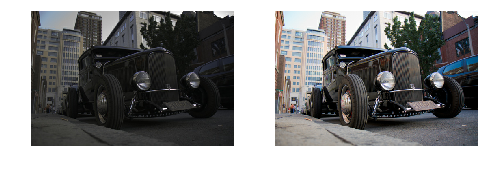

In [88]:
f, axes = plt.subplots(1,2)
for ax in axes:
  ax.grid(False)
  ax.axis('off')
axes[0].imshow(origin)
axes[1].imshow(target)

In [0]:
# Take a subset of all images
img_pool = img_names[:50]
test_img = img_names[:-50]

Instantiate the agent with 64 buffer size and 4 batch size

In [0]:
agt = Agent(buffer_size=64, batch_size=4, lr=1e-5)

In [0]:
STEPS = 50

In [92]:
img_count = 0
for img in img_pool:
  img_count += 1

  targ_path = '../../photos/target/' + img
  org_path = '../../photos/origin/' + img
  targ_img = read_image(targ_path)
  org_img = read_image(org_path)

  print('set target {}'.format(img_count))
  agt.setTarget(targ_img)

  for s in range(STEPS):
    expe, aft_img = agt.step(org_img)
    agt.record(expe[0], expe[1], expe[2], expe[3])
    # agent will start learning once the buffer has more than one batch
    flag = agt.learn()

    # Only replace the image when agent start learning
    if flag:
      org_img = aft_img

    if s % 10 == 0:
      print('learning...\n{}-th image, step {}, action {} is taken, reward {}'.format(
            img_count, s, expe[1], expe[3]))

set target 1
learning...
1-th image, step 0, action 9 is taken, reward -0.502497568308609
learning...
1-th image, step 10, action 4 is taken, reward 0.6008408289465912
learning...
1-th image, step 20, action 4 is taken, reward 0.5201524740967098
learning...
1-th image, step 30, action 4 is taken, reward -0.1453610381003907
learning...
1-th image, step 40, action 4 is taken, reward -0.4981313310347222
set target 2
learning...
2-th image, step 0, action 4 is taken, reward 0.31651683599805125
learning...
2-th image, step 10, action 4 is taken, reward 0.5962976822749759
learning...
2-th image, step 20, action 4 is taken, reward 0.533736867025576
learning...
2-th image, step 30, action 4 is taken, reward 0.2651996136032677
learning...
2-th image, step 40, action 4 is taken, reward -0.822097621201543
set target 3
learning...
3-th image, step 0, action 4 is taken, reward 0.30312407986489376
learning...
3-th image, step 10, action 4 is taken, reward 0.37207192869387384
learning...
3-th image, 

### Evaluation
1. Use our trained agent to improve raw images
1. For each images, iterate 100 steps, track the l2 loss

In [0]:
from action import actionlst
from feature_extractor.feature_extractor import ContextExtractor, get_histogram 
from agent import combine

In [0]:
VGG_SHAPE = 224

# Get state of an image
def getState(img, ctx_extractor):
  img_resize = tf.image.resize_images(img, [VGG_SHAPE, VGG_SHAPE]) / 255.0
  ctx = ctx_extractor(img_resize.numpy())
  color = get_histogram(img)
  return combine(color, ctx)

# Return l2 loss between target and image states
def loss(target_state, state):
  return LA.norm(target_state - state)

First, let's examine the color improvement process for one image. We plot the loss against the iterations

In [0]:
raw_path = '../../photos/origin/' + test_img[1]
targ_path = '../../photos/target/' + test_img[1]
raw_img = read_image(raw_path)
targ_img = read_image(targ_path)

Examine the raw image

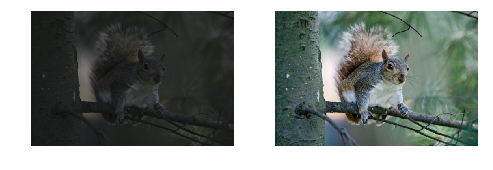

In [102]:
f, axes = plt.subplots(1,2)
for ax in axes:
  ax.grid(False)
  ax.axis('off')
axes[0].imshow(raw_img)
axes[1].imshow(targ_img)

In [0]:
ce = ContextExtractor()
target_state = getState(targ_img, ce)
distance = []

src = raw_img
for s in range(50):
  src, state_cur = agt.predict(src)
  l = loss(target_state, state_cur)
  distance.append(l)

Text(0,0.5,'l2 distance between target and image state')

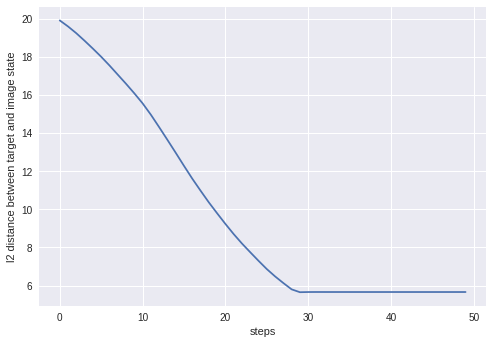

In [109]:
x = np.arange(50)
plt.plot(x, distance)
plt.xlabel('steps')
plt.ylabel('l2 distance between target and image state')

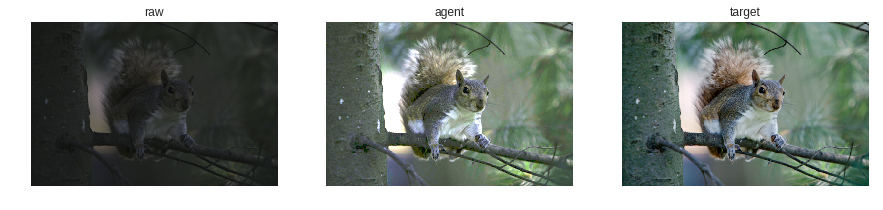

In [114]:
f, axes = plt.subplots(1,3,figsize=(15,15))
for ax in axes:
  ax.grid(False)
  ax.axis('off')
axes[0].imshow(raw_img)
axes[1].imshow(src)
axes[2].imshow(targ_img)
axes[0].title.set_text('raw')
axes[1].title.set_text('agent')
axes[2].title.set_text('target')


### TODO
1. Visualize the target baseline
1. Resolve the termination condition
1. Change the training to epsilon-greedy